In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms, models
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

class NumberDataset(Dataset):
    def __init__(self, transform = None):
        root = '/kaggle/input/numta'
        file_list = ['training-a', 'training-b', 'training-c', 'training-d','training-e']
        self.imdb = []
        self.transform = transform
        
        for file in file_list:
            csv_file = os.path.join(root, file+'.csv')
            labels = pd.read_csv(csv_file)[['database name','filename','digit']].values

            for element in labels:
                file_name = os.path.join(root, element[0], element[1])
                label = element[2]
                self.imdb.append((file_name,label))
    
    def __len__(self):
        return len(self.imdb)
    
    def __getitem__(self, index):
        path, label = self.imdb[index]
        image = Image.open(path).convert('L')
        
        if self.transform is not None:
            image = self.transform(image)
        
        return image, label
        



In [2]:
model = models.resnet50()
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(in_features=2048, out_features=10, bias=True)
model.cuda()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [3]:
mean = [0.5,]
std = [0.5, ]

train_transform = transforms.Compose([
    transforms.Resize((28,28)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
        transforms.Resize((28,28)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

train_data  = NumberDataset(train_transform)
test_data = NumberDataset(test_transform)

In [4]:
batch_size = 32
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(train_data)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
    
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
test_loader = DataLoader(test_data, batch_size=batch_size, sampler=test_sampler)

In [5]:
learning_rate = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

epochs = 100
test_loss_min = np.Inf
train_loss_data, test_loss_data = [], []
iteration = 0

for e in range(epochs):
    running_loss = 0
    train_loss = 0.0
    test_loss = 0.0
    total = 0
    correct = 0
    print("========================Epoch:{}=======================".format(e+1))
    
    for images, labels in train_loader:
        images, labels = images.cuda(), labels.cuda()
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)


    for images, labels in test_loader:
        images, labels = images.cuda(), labels.cuda()
        logits = model(images)
        loss = criterion(logits, labels)
        test_loss += loss.item() * images.size(0)
        proba = torch.exp(logits)
        top_p, top_class = proba.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)

        _, predicted = torch.max(logits.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


    train_loss = train_loss / len(train_loader.dataset)
    test_loss = test_loss / len(test_loader.dataset)

    train_loss_data.append(train_loss * 100)
    test_loss_data.append(test_loss * 100)

    accuracy = (correct / total) * 100
    
    print("Train loss:{:.6f}..".format(train_loss), "\tValid Loss:{:.6f}..".format(test_loss),"\tAccuracy: {:.4f}".format(accuracy))
    
    if test_loss <= test_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(test_loss_min,test_loss))
        torch.save(model.state_dict(), 'model_final.pt')
        test_loss_min = test_loss

========================Epoch:1=======================
Train loss:1.211473.. 	Valid Loss:0.193346.. 	Accuracy: 66.8749
Validation loss decreased (inf --> 0.193346).  Saving model ...
========================Epoch:2=======================
Train loss:0.588464.. 	Valid Loss:0.110819.. 	Accuracy: 81.2964
Validation loss decreased (0.193346 --> 0.110819).  Saving model ...
========================Epoch:3=======================
Train loss:0.378478.. 	Valid Loss:0.091014.. 	Accuracy: 84.3362
Validation loss decreased (0.110819 --> 0.091014).  Saving model ...
========================Epoch:4=======================
Train loss:0.267292.. 	Valid Loss:0.067207.. 	Accuracy: 88.8334
Validation loss decreased (0.091014 --> 0.067207).  Saving model ...
========================Epoch:5=======================
Train loss:0.204981.. 	Valid Loss:0.059603.. 	Accuracy: 90.3394
Validation loss decreased (0.067207 --> 0.059603).  Saving model ...
========================Epoch:6=======================
Train loss

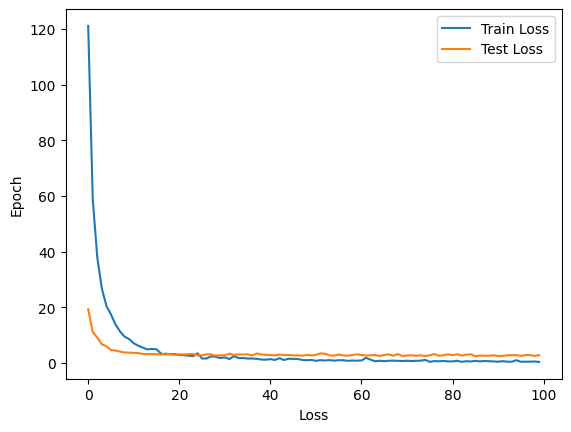

In [6]:
plt.plot(train_loss_data, label = 'Train Loss')
plt.plot(test_loss_data, label = 'Test Loss')
plt.xlabel('Loss')
plt.ylabel('Epoch')
plt.legend()
plt.show()